In [6]:
import cv2
import numpy as np
import pandas as pd 

from tqdm.notebook import tqdm_notebook
import time

from datetime import timedelta

import ffmpeg

# import os.path
import os
import glob

In [7]:
class Transition:
    
    def __init__(self, start, end):
        self.start = start
        self.end = end

In [8]:
class Params:
#     title = "xiaoxianrou"
#     start_time = '00:01:12'
#     end_time = '00:33:24'
#     title = "996"
#     start_time = '00:01:12'
#     end_time = '00:33:24'
#     title = "beauty"
#     title = "stereotypes"
#     transitions = [
#         Transition(timedelta(minutes=7, seconds=14, milliseconds=920), timedelta(minutes=7, seconds=15, milliseconds=760)),
#         Transition(timedelta(minutes=14, seconds=31, milliseconds=480), timedelta(minutes=14, seconds=33, milliseconds=0)),
#         Transition(timedelta(minutes=16, seconds=4, milliseconds=760), timedelta(minutes=16, seconds=5, milliseconds=600)),
#         Transition(timedelta(minutes=23, seconds=2, milliseconds=200), timedelta(minutes=23, seconds=8, milliseconds=520)),
#         Transition(timedelta(minutes=26, seconds=46, milliseconds=920), timedelta(minutes=26, seconds=47, milliseconds=440)),
#         Transition(timedelta(minutes=34, seconds=24, milliseconds=400), timedelta(minutes=34, seconds=25, milliseconds=520)),
#     ]
#
#     title = "livestreaming"
#     transitions = []
    title = "lying_flat"
    transitions = [
#         Transition(timedelta(minutes=7, seconds=14, milliseconds=920), timedelta(minutes=7, seconds=15, milliseconds=760)),
    ]


In [9]:
# video_file = Params.title + "_original.mp4"
# outfile = Params.title + "_cut.mp4"

# ffmpeg.input(video_file, ss=Params.start_time, to=Params.end_time, vcodec="libx264", acodec="aac").output(outfile).run()

In [10]:
def in_transition(time_millis):
    for i in Params.transitions:
        if i.start.total_seconds()*1000 <= time_millis <= i.end.total_seconds() * 1000:
            return True
    
    return False

In [11]:
# vidcap = cv2.VideoCapture('trimmed.mp4')
vidcap = cv2.VideoCapture(Params.title + '.mp4')
success,image = vidcap.read()
count = 0
frame_count=0
transition_count = 0

fileList = glob.glob('/home/daniel/programming/chinese/mandarin_corner/frames/*.jpg')
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

# while success and count <= 12000:
# while success and count <= 50000:
while success:
    #TODO check if the current frame is in a transition
    position_millis = vidcap.get(cv2.CAP_PROP_POS_MSEC)
#     if transition_count < len(Params.transitions) and position_millis > Params.transitions[transition_count].start.total_seconds() * 1000 and position_millis < Params.transitions[transition_count].end.total_seconds() * 1000:
    if in_transition(position_millis):
        print("Skipped a transition", count)
#         transition_count += 1
        success,image = vidcap.read()
        count += 1
        frame_count += 10000
        continue
    cv2.imwrite("frames/frame%d.jpg" % count, image[0:94, 1817:1920])     # crop out the subtitle number and save as JPEG file      
    success,image = vidcap.read()
#     print('Read a new frame: ', success)
    count += 1
    frame_count += 10000

In [12]:
xc = 40
yc = 52
radius = 25

im = cv2.imread('frames/frame0.jpg')
height,width,depth = im.shape
circle_img = np.zeros((height,width), np.uint8)
cv2.circle(circle_img,(xc,yc),radius,1,thickness=-1)
# cv2.imshow("circle_img", circle_img)

masked_data = cv2.bitwise_and(im, im, mask=circle_img)

# cv2.imshow("masked", masked_data)
# cv2.waitKey(0)

# cv2.destroyAllWindows()

In [13]:
import glob
num_frames = len(glob.glob1("./frames/","*.jpg"))

In [14]:
# import the necessary packages
from skimage.metrics import structural_similarity as compare_ssim
import imutils

xc = 40
yc = 52
radius = 25
im = cv2.imread('frames/frame0.jpg')
height,width,depth = im.shape
circle_img = np.zeros((height,width), np.uint8)
cv2.circle(circle_img,(xc,yc),radius,1,thickness=-1)
# cv2.circle(circle_img,(xc,yc),32,1,thickness=-1)

frames = {0 : 0}
j = 0
diffs = []
is_in_transition = False

for i in tqdm_notebook(range(num_frames - 1)):
    # subtract 1 so can compare to the final frame
    fileA = 'frames/frame' + str(i) + '.jpg'
    fileB = 'frames/frame' + str(i+1) + '.jpg'
    if not os.path.isfile(fileA) and os.path.isfile(fileB):
        is_in_transition = False
        j += 1 
        # need to cut the subtitle earlier, frames[j] should be min/max of i+1 and something 
        frames[j] = i+1
        continue
    if not os.path.isfile(fileA) or not os.path.isfile(fileB):
        is_in_transition = True
        continue
    imageA = cv2.imread(fileA)
    imageB = cv2.imread(fileB)
    maskedA =cv2.bitwise_and(imageA, imageA, mask=circle_img)
    maskedB =cv2.bitwise_and(imageB, imageB, mask=circle_img)
    dstA = cv2.GaussianBlur(maskedA,(5,5),cv2.BORDER_DEFAULT)
    dstB = cv2.GaussianBlur(maskedB,(5,5),cv2.BORDER_DEFAULT)
    grayA = cv2.cvtColor(dstA, cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(dstB, cv2.COLOR_BGR2GRAY)
    (score, diff) = compare_ssim(grayA, grayB, full=True)
    diff = (diff * 255).astype("uint8")
    diffs.append(score)
    if score <= 0.99:
        j += 1
        frames[j] = i+1
print(j)

cv2.destroyAllWindows()

  0%|          | 0/43303 [00:00<?, ?it/s]

514


In [15]:
df = pd.DataFrame(diffs)

<AxesSubplot:>

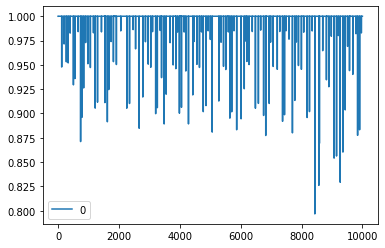

In [16]:
df[0:10000].plot()

In [17]:
from pprint import pprint

pprint(frames)

{0: 0,
 1: 121,
 2: 200,
 3: 273,
 4: 334,
 5: 399,
 6: 506,
 7: 556,
 8: 662,
 9: 742,
 10: 784,
 11: 843,
 12: 908,
 13: 983,
 14: 1063,
 15: 1164,
 16: 1221,
 17: 1298,
 18: 1427,
 19: 1540,
 20: 1621,
 21: 1667,
 22: 1744,
 23: 1820,
 24: 1918,
 25: 2061,
 26: 2259,
 27: 2349,
 28: 2468,
 29: 2548,
 30: 2666,
 31: 2785,
 32: 2872,
 33: 2964,
 34: 3046,
 35: 3105,
 36: 3208,
 37: 3263,
 38: 3357,
 39: 3401,
 40: 3487,
 41: 3552,
 42: 3681,
 43: 3782,
 44: 3871,
 45: 3926,
 46: 3988,
 47: 4056,
 48: 4144,
 49: 4198,
 50: 4286,
 51: 4427,
 52: 4470,
 53: 4564,
 54: 4647,
 55: 4714,
 56: 4772,
 57: 4861,
 58: 4932,
 59: 5004,
 60: 5066,
 61: 5283,
 62: 5356,
 63: 5437,
 64: 5512,
 65: 5596,
 66: 5645,
 67: 5707,
 68: 5781,
 69: 5869,
 70: 6014,
 71: 6119,
 72: 6174,
 73: 6205,
 74: 6277,
 75: 6382,
 76: 6485,
 77: 6583,
 78: 6658,
 79: 6754,
 80: 6824,
 81: 6939,
 82: 6984,
 83: 7069,
 84: 7204,
 85: 7285,
 86: 7377,
 87: 7441,
 88: 7493,
 89: 7589,
 90: 7701,
 91: 7780,
 92: 7830,
 93

In [18]:
cap = cv2.VideoCapture(Params.title + '.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)

timestamps = [cap.get(cv2.CAP_PROP_POS_MSEC)]
# calc_timestamps = [0.0]

while(cap.isOpened()):
    frame_exists, curr_frame = cap.read()
    if frame_exists:
        timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC))
#         calc_timestamps.append(calc_timestamps[-1] + 1000/fps)
    else:
        break

cap.release()

In [19]:
len(timestamps)

43305

In [20]:
pprint(timestamps)

[0.0,
 0.0,
 40.0,
 80.0,
 120.0,
 160.0,
 200.0,
 240.0,
 280.0,
 320.0,
 360.0,
 400.0,
 440.0,
 480.0,
 520.0,
 560.0,
 600.0,
 640.0,
 680.0,
 720.0,
 760.0,
 800.0,
 840.0,
 880.0,
 920.0,
 960.0,
 1000.0,
 1040.0,
 1080.0,
 1120.0,
 1160.0,
 1200.0,
 1240.0,
 1280.0,
 1320.0,
 1360.0,
 1400.0000000000002,
 1440.0,
 1480.0,
 1520.0,
 1560.0,
 1600.0,
 1640.0000000000002,
 1680.0,
 1720.0,
 1760.0,
 1800.0,
 1840.0,
 1880.0000000000002,
 1920.0,
 1960.0,
 2000.0,
 2040.0,
 2080.0,
 2120.0,
 2160.0,
 2200.0,
 2240.0,
 2280.0000000000005,
 2320.0,
 2360.0,
 2400.0,
 2440.0,
 2480.0,
 2520.0,
 2560.0,
 2600.0,
 2640.0,
 2680.0,
 2720.0,
 2760.0000000000005,
 2800.0000000000005,
 2840.0,
 2880.0,
 2920.0,
 2960.0,
 3000.0,
 3040.0,
 3080.0,
 3120.0,
 3160.0,
 3200.0,
 3240.0,
 3280.0000000000005,
 3320.0000000000005,
 3360.0,
 3400.0,
 3440.0,
 3480.0,
 3520.0,
 3560.0,
 3600.0,
 3640.0,
 3680.0,
 3720.0,
 3760.0000000000005,
 3800.0000000000005,
 3840.0,
 3880.0,
 3920.0,
 3960.0,
 40

 301200.0,
 301240.0,
 301280.00000000006,
 301320.0,
 301360.0,
 301400.00000000006,
 301440.0,
 301480.0,
 301520.0,
 301560.0,
 301600.0,
 301640.0,
 301680.0,
 301720.0,
 301760.0,
 301800.0,
 301840.00000000006,
 301880.0,
 301920.0,
 301960.0,
 302000.0,
 302040.0,
 302080.0,
 302120.0,
 302160.0,
 302200.0,
 302240.0,
 302280.00000000006,
 302320.0,
 302360.0,
 302400.00000000006,
 302440.0,
 302480.0,
 302520.0,
 302560.0,
 302600.0,
 302640.0,
 302680.0,
 302720.0,
 302760.0,
 302800.0,
 302840.00000000006,
 302880.0,
 302920.0,
 302960.0,
 303000.0,
 303040.0,
 303080.0,
 303120.0,
 303160.0,
 303200.0,
 303240.0,
 303280.00000000006,
 303320.0,
 303360.0,
 303400.00000000006,
 303440.0,
 303480.0,
 303520.0,
 303560.0,
 303600.0,
 303640.0,
 303680.0,
 303720.0,
 303760.0,
 303800.0,
 303840.00000000006,
 303880.0,
 303920.0,
 303960.0,
 304000.0,
 304040.0,
 304080.0,
 304120.0,
 304160.0,
 304200.0,
 304240.0,
 304280.00000000006,
 304320.0,
 304360.0,
 304400.00000000006,

 553320.0,
 553360.0,
 553400.0,
 553440.0,
 553480.0,
 553520.0,
 553560.0000000001,
 553600.0,
 553640.0,
 553680.0000000001,
 553720.0,
 553760.0,
 553800.0000000001,
 553840.0,
 553880.0,
 553920.0,
 553960.0,
 554000.0,
 554040.0,
 554080.0,
 554120.0,
 554160.0,
 554200.0,
 554240.0,
 554280.0,
 554320.0,
 554360.0,
 554400.0,
 554440.0,
 554480.0,
 554520.0,
 554560.0000000001,
 554600.0,
 554640.0,
 554680.0000000001,
 554720.0,
 554760.0,
 554800.0000000001,
 554840.0,
 554880.0,
 554920.0,
 554960.0,
 555000.0,
 555040.0,
 555080.0,
 555120.0,
 555160.0,
 555200.0,
 555240.0,
 555280.0,
 555320.0,
 555360.0,
 555400.0,
 555440.0,
 555480.0,
 555520.0,
 555560.0000000001,
 555600.0,
 555640.0,
 555680.0000000001,
 555720.0,
 555760.0,
 555800.0000000001,
 555840.0,
 555880.0,
 555920.0,
 555960.0,
 556000.0,
 556040.0,
 556080.0,
 556120.0,
 556160.0,
 556200.0,
 556240.0,
 556280.0,
 556320.0,
 556360.0,
 556400.0,
 556440.0,
 556480.0,
 556520.0,
 556560.0000000001,
 556600.

 866400.0,
 866440.0,
 866480.0,
 866520.0,
 866560.0000000001,
 866600.0,
 866640.0,
 866680.0000000001,
 866720.0,
 866760.0,
 866800.0000000001,
 866840.0,
 866880.0,
 866920.0000000001,
 866960.0,
 867000.0,
 867040.0,
 867080.0,
 867120.0,
 867160.0,
 867200.0,
 867240.0,
 867280.0,
 867320.0,
 867360.0,
 867400.0,
 867440.0,
 867480.0,
 867520.0,
 867560.0000000001,
 867600.0,
 867640.0,
 867680.0000000001,
 867720.0,
 867760.0,
 867800.0000000001,
 867840.0,
 867880.0,
 867920.0000000001,
 867960.0,
 868000.0,
 868040.0,
 868080.0,
 868120.0,
 868160.0,
 868200.0,
 868240.0,
 868280.0,
 868320.0,
 868360.0,
 868400.0,
 868440.0,
 868480.0,
 868520.0,
 868560.0000000001,
 868600.0,
 868640.0,
 868680.0000000001,
 868720.0,
 868760.0,
 868800.0000000001,
 868840.0,
 868880.0,
 868920.0000000001,
 868960.0,
 869000.0,
 869040.0,
 869080.0,
 869120.0,
 869160.0,
 869200.0,
 869240.0,
 869280.0,
 869320.0,
 869360.0,
 869400.0,
 869440.0,
 869480.0,
 869520.0,
 869560.0000000001,
 86

 1175120.0000000002,
 1175160.0,
 1175200.0,
 1175240.0,
 1175280.0,
 1175320.0,
 1175360.0000000002,
 1175400.0,
 1175440.0,
 1175480.0,
 1175520.0,
 1175560.0,
 1175600.0000000002,
 1175640.0,
 1175680.0,
 1175720.0,
 1175760.0,
 1175800.0,
 1175840.0,
 1175880.0,
 1175920.0,
 1175960.0,
 1176000.0,
 1176040.0,
 1176080.0,
 1176120.0000000002,
 1176160.0,
 1176200.0,
 1176240.0,
 1176280.0,
 1176320.0,
 1176360.0000000002,
 1176400.0,
 1176440.0,
 1176480.0,
 1176520.0,
 1176560.0,
 1176600.0000000002,
 1176640.0,
 1176680.0,
 1176720.0,
 1176760.0,
 1176800.0,
 1176840.0,
 1176880.0,
 1176920.0,
 1176960.0,
 1177000.0,
 1177040.0,
 1177080.0,
 1177120.0000000002,
 1177160.0,
 1177200.0,
 1177240.0,
 1177280.0,
 1177320.0,
 1177360.0000000002,
 1177400.0,
 1177440.0,
 1177480.0,
 1177520.0,
 1177560.0,
 1177600.0000000002,
 1177640.0,
 1177680.0,
 1177720.0,
 1177760.0,
 1177800.0,
 1177840.0,
 1177880.0,
 1177920.0,
 1177960.0,
 1178000.0,
 1178040.0,
 1178080.0,
 1178120.0000000002

 1482840.0,
 1482880.0,
 1482920.0,
 1482960.0,
 1483000.0,
 1483040.0,
 1483080.0,
 1483120.0000000002,
 1483160.0,
 1483200.0,
 1483240.0,
 1483280.0,
 1483320.0,
 1483360.0000000002,
 1483400.0,
 1483440.0,
 1483480.0,
 1483520.0,
 1483560.0,
 1483600.0000000002,
 1483640.0,
 1483680.0,
 1483720.0,
 1483760.0,
 1483800.0,
 1483840.0,
 1483880.0,
 1483920.0,
 1483960.0,
 1484000.0,
 1484040.0,
 1484080.0,
 1484120.0000000002,
 1484160.0,
 1484200.0,
 1484240.0,
 1484280.0,
 1484320.0,
 1484360.0000000002,
 1484400.0,
 1484440.0,
 1484480.0,
 1484520.0,
 1484560.0,
 1484600.0000000002,
 1484640.0,
 1484680.0,
 1484720.0,
 1484760.0,
 1484800.0,
 1484840.0,
 1484880.0,
 1484920.0,
 1484960.0,
 1485000.0,
 1485040.0,
 1485080.0,
 1485120.0000000002,
 1485160.0,
 1485200.0,
 1485240.0,
 1485280.0,
 1485320.0,
 1485360.0000000002,
 1485400.0,
 1485440.0,
 1485480.0,
 1485520.0,
 1485560.0,
 1485600.0000000002,
 1485640.0,
 1485680.0,
 1485720.0,
 1485760.0,
 1485800.0,
 1485840.0,
 148588

In [21]:
# for k in range(2, len(timestamps)):
#     if timestamps[k] == 0.0:
#         timestamps[k] = (timestamps[k-1] + timestamps[k+1])/2

In [22]:
pprint(timestamps)

[0.0,
 0.0,
 40.0,
 80.0,
 120.0,
 160.0,
 200.0,
 240.0,
 280.0,
 320.0,
 360.0,
 400.0,
 440.0,
 480.0,
 520.0,
 560.0,
 600.0,
 640.0,
 680.0,
 720.0,
 760.0,
 800.0,
 840.0,
 880.0,
 920.0,
 960.0,
 1000.0,
 1040.0,
 1080.0,
 1120.0,
 1160.0,
 1200.0,
 1240.0,
 1280.0,
 1320.0,
 1360.0,
 1400.0000000000002,
 1440.0,
 1480.0,
 1520.0,
 1560.0,
 1600.0,
 1640.0000000000002,
 1680.0,
 1720.0,
 1760.0,
 1800.0,
 1840.0,
 1880.0000000000002,
 1920.0,
 1960.0,
 2000.0,
 2040.0,
 2080.0,
 2120.0,
 2160.0,
 2200.0,
 2240.0,
 2280.0000000000005,
 2320.0,
 2360.0,
 2400.0,
 2440.0,
 2480.0,
 2520.0,
 2560.0,
 2600.0,
 2640.0,
 2680.0,
 2720.0,
 2760.0000000000005,
 2800.0000000000005,
 2840.0,
 2880.0,
 2920.0,
 2960.0,
 3000.0,
 3040.0,
 3080.0,
 3120.0,
 3160.0,
 3200.0,
 3240.0,
 3280.0000000000005,
 3320.0000000000005,
 3360.0,
 3400.0,
 3440.0,
 3480.0,
 3520.0,
 3560.0,
 3600.0,
 3640.0,
 3680.0,
 3720.0,
 3760.0000000000005,
 3800.0000000000005,
 3840.0,
 3880.0,
 3920.0,
 3960.0,
 40

 302920.0,
 302960.0,
 303000.0,
 303040.0,
 303080.0,
 303120.0,
 303160.0,
 303200.0,
 303240.0,
 303280.00000000006,
 303320.0,
 303360.0,
 303400.00000000006,
 303440.0,
 303480.0,
 303520.0,
 303560.0,
 303600.0,
 303640.0,
 303680.0,
 303720.0,
 303760.0,
 303800.0,
 303840.00000000006,
 303880.0,
 303920.0,
 303960.0,
 304000.0,
 304040.0,
 304080.0,
 304120.0,
 304160.0,
 304200.0,
 304240.0,
 304280.00000000006,
 304320.0,
 304360.0,
 304400.00000000006,
 304440.0,
 304480.0,
 304520.0,
 304560.0,
 304600.0,
 304640.0,
 304680.0,
 304720.0,
 304760.0,
 304800.0,
 304840.00000000006,
 304880.0,
 304920.0,
 304960.0,
 305000.0,
 305040.0,
 305080.0,
 305120.0,
 305160.0,
 305200.0,
 305240.0,
 305280.00000000006,
 305320.0,
 305360.0,
 305400.00000000006,
 305440.0,
 305480.0,
 305520.0,
 305560.0,
 305600.0,
 305640.0,
 305680.0,
 305720.0,
 305760.0,
 305800.0,
 305840.00000000006,
 305880.0,
 305920.0,
 305960.0,
 306000.0,
 306040.0,
 306080.0,
 306120.0,
 306160.0,
 306200.

 606120.0,
 606160.0,
 606200.0,
 606240.0,
 606280.0,
 606320.0,
 606360.0,
 606400.0,
 606440.0,
 606480.0,
 606520.0,
 606560.0000000001,
 606600.0,
 606640.0,
 606680.0000000001,
 606720.0,
 606760.0,
 606800.0000000001,
 606840.0,
 606880.0,
 606920.0,
 606960.0,
 607000.0,
 607040.0,
 607080.0,
 607120.0,
 607160.0,
 607200.0,
 607240.0,
 607280.0,
 607320.0,
 607360.0,
 607400.0,
 607440.0,
 607480.0,
 607520.0,
 607560.0000000001,
 607600.0,
 607640.0,
 607680.0000000001,
 607720.0,
 607760.0,
 607800.0000000001,
 607840.0,
 607880.0,
 607920.0,
 607960.0,
 608000.0,
 608040.0,
 608080.0,
 608120.0,
 608160.0,
 608200.0,
 608240.0,
 608280.0,
 608320.0,
 608360.0,
 608400.0,
 608440.0,
 608480.0,
 608520.0,
 608560.0000000001,
 608600.0,
 608640.0,
 608680.0000000001,
 608720.0,
 608760.0,
 608800.0000000001,
 608840.0,
 608880.0,
 608920.0,
 608960.0,
 609000.0,
 609040.0,
 609080.0,
 609120.0,
 609160.0,
 609200.0,
 609240.0,
 609280.0,
 609320.0,
 609360.0,
 609400.0,
 60944

 926080.0,
 926120.0,
 926160.0,
 926200.0,
 926240.0,
 926280.0,
 926320.0,
 926360.0,
 926400.0,
 926440.0,
 926480.0,
 926520.0,
 926560.0000000001,
 926600.0,
 926640.0,
 926680.0000000001,
 926720.0,
 926760.0,
 926800.0000000001,
 926840.0,
 926880.0,
 926920.0000000001,
 926960.0,
 927000.0,
 927040.0,
 927080.0,
 927120.0,
 927160.0,
 927200.0,
 927240.0,
 927280.0,
 927320.0,
 927360.0,
 927400.0,
 927440.0,
 927480.0,
 927520.0,
 927560.0000000001,
 927600.0,
 927640.0,
 927680.0000000001,
 927720.0,
 927760.0,
 927800.0000000001,
 927840.0,
 927880.0,
 927920.0000000001,
 927960.0,
 928000.0,
 928040.0,
 928080.0,
 928120.0,
 928160.0,
 928200.0,
 928240.0,
 928280.0,
 928320.0,
 928360.0,
 928400.0,
 928440.0,
 928480.0,
 928520.0,
 928560.0000000001,
 928600.0,
 928640.0,
 928680.0000000001,
 928720.0,
 928760.0,
 928800.0000000001,
 928840.0,
 928880.0,
 928920.0000000001,
 928960.0,
 929000.0,
 929040.0,
 929080.0,
 929120.0,
 929160.0,
 929200.0,
 929240.0,
 929280.0,
 

 1246080.0,
 1246120.0000000002,
 1246160.0,
 1246200.0,
 1246240.0,
 1246280.0,
 1246320.0,
 1246360.0000000002,
 1246400.0,
 1246440.0,
 1246480.0,
 1246520.0,
 1246560.0,
 1246600.0000000002,
 1246640.0,
 1246680.0,
 1246720.0,
 1246760.0,
 1246800.0,
 1246840.0,
 1246880.0,
 1246920.0,
 1246960.0,
 1247000.0,
 1247040.0,
 1247080.0,
 1247120.0000000002,
 1247160.0,
 1247200.0,
 1247240.0,
 1247280.0,
 1247320.0,
 1247360.0000000002,
 1247400.0,
 1247440.0,
 1247480.0,
 1247520.0,
 1247560.0,
 1247600.0000000002,
 1247640.0,
 1247680.0,
 1247720.0,
 1247760.0,
 1247800.0,
 1247840.0,
 1247880.0,
 1247920.0,
 1247960.0,
 1248000.0,
 1248040.0,
 1248080.0,
 1248120.0000000002,
 1248160.0,
 1248200.0,
 1248240.0,
 1248280.0,
 1248320.0,
 1248360.0000000002,
 1248400.0,
 1248440.0,
 1248480.0,
 1248520.0,
 1248560.0,
 1248600.0000000002,
 1248640.0,
 1248680.0,
 1248720.0,
 1248760.0,
 1248800.0,
 1248840.0,
 1248880.0,
 1248920.0,
 1248960.0,
 1249000.0,
 1249040.0,
 1249080.0,
 124912

 1530720.0,
 1530760.0,
 1530800.0,
 1530840.0000000002,
 1530880.0,
 1530920.0,
 1530960.0,
 1531000.0,
 1531040.0,
 1531080.0,
 1531120.0000000002,
 1531160.0,
 1531200.0,
 1531240.0,
 1531280.0,
 1531320.0,
 1531360.0000000002,
 1531400.0,
 1531440.0,
 1531480.0,
 1531520.0,
 1531560.0,
 1531600.0000000002,
 1531640.0,
 1531680.0,
 1531720.0,
 1531760.0,
 1531800.0,
 1531840.0000000002,
 1531880.0,
 1531920.0,
 1531960.0,
 1532000.0,
 1532040.0,
 1532080.0,
 1532120.0000000002,
 1532160.0,
 1532200.0,
 1532240.0,
 1532280.0,
 1532320.0,
 1532360.0000000002,
 1532400.0,
 1532440.0,
 1532480.0,
 1532520.0,
 1532560.0,
 1532600.0000000002,
 1532640.0,
 1532680.0,
 1532720.0,
 1532760.0,
 1532800.0,
 1532840.0000000002,
 1532880.0,
 1532920.0,
 1532960.0,
 1533000.0,
 1533040.0,
 1533080.0,
 1533120.0000000002,
 1533160.0,
 1533200.0,
 1533240.0,
 1533280.0,
 1533320.0,
 1533360.0000000002,
 1533400.0,
 1533440.0,
 1533480.0,
 1533520.0,
 1533560.0,
 1533600.0000000002,
 1533640.0,
 153

In [23]:
frame_to_timestamp = dict()

In [24]:
for i in frames.values():
    frame_to_timestamp[i] = timestamps[i]

In [25]:
pprint(frame_to_timestamp)

{0: 0.0,
 121: 4800.0,
 200: 7960.0,
 273: 10880.0,
 334: 13320.0,
 399: 15920.0,
 506: 20200.0,
 556: 22200.0,
 662: 26440.0,
 742: 29640.0,
 784: 31320.0,
 843: 33680.0,
 908: 36280.0,
 983: 39280.0,
 1063: 42480.00000000001,
 1164: 46520.0,
 1221: 48800.00000000001,
 1298: 51880.0,
 1427: 57040.0,
 1540: 61560.0,
 1621: 64800.0,
 1667: 66640.0,
 1744: 69720.0,
 1820: 72760.0,
 1918: 76680.0,
 2061: 82400.0,
 2259: 90320.00000000001,
 2349: 93920.0,
 2468: 98680.0,
 2548: 101880.0,
 2666: 106600.00000000001,
 2785: 111360.0,
 2872: 114840.0,
 2964: 118520.0,
 3046: 121800.0,
 3105: 124160.0,
 3208: 128280.0,
 3263: 130479.99999999999,
 3357: 134240.0,
 3401: 136000.0,
 3487: 139440.0,
 3552: 142040.0,
 3681: 147200.00000000003,
 3782: 151240.0,
 3871: 154800.0,
 3926: 157000.0,
 3988: 159480.0,
 4056: 162200.00000000003,
 4144: 165720.0,
 4198: 167880.0,
 4286: 171400.0,
 4427: 177040.0,
 4470: 178760.0,
 4564: 182520.0,
 4647: 185840.0,
 4714: 188520.0,
 4772: 190840.0,
 4861: 19440

In [26]:
frame_milis = { k: timedelta(milliseconds=v) for k,v in frame_to_timestamp.items()}

In [27]:
pprint(frame_milis)

{0: datetime.timedelta(0),
 121: datetime.timedelta(seconds=4, microseconds=800000),
 200: datetime.timedelta(seconds=7, microseconds=960000),
 273: datetime.timedelta(seconds=10, microseconds=880000),
 334: datetime.timedelta(seconds=13, microseconds=320000),
 399: datetime.timedelta(seconds=15, microseconds=920000),
 506: datetime.timedelta(seconds=20, microseconds=200000),
 556: datetime.timedelta(seconds=22, microseconds=200000),
 662: datetime.timedelta(seconds=26, microseconds=440000),
 742: datetime.timedelta(seconds=29, microseconds=640000),
 784: datetime.timedelta(seconds=31, microseconds=320000),
 843: datetime.timedelta(seconds=33, microseconds=680000),
 908: datetime.timedelta(seconds=36, microseconds=280000),
 983: datetime.timedelta(seconds=39, microseconds=280000),
 1063: datetime.timedelta(seconds=42, microseconds=480000),
 1164: datetime.timedelta(seconds=46, microseconds=520000),
 1221: datetime.timedelta(seconds=48, microseconds=800000),
 1298: datetime.timedelta(se

 29575: datetime.timedelta(seconds=1182, microseconds=960000),
 29608: datetime.timedelta(seconds=1184, microseconds=280000),
 29679: datetime.timedelta(seconds=1187, microseconds=120000),
 29745: datetime.timedelta(seconds=1189, microseconds=760000),
 29791: datetime.timedelta(seconds=1191, microseconds=600000),
 29858: datetime.timedelta(seconds=1194, microseconds=280000),
 29944: datetime.timedelta(seconds=1197, microseconds=720000),
 30077: datetime.timedelta(seconds=1203, microseconds=40000),
 30131: datetime.timedelta(seconds=1205, microseconds=200000),
 30208: datetime.timedelta(seconds=1208, microseconds=280000),
 30267: datetime.timedelta(seconds=1210, microseconds=640000),
 30346: datetime.timedelta(seconds=1213, microseconds=800000),
 30446: datetime.timedelta(seconds=1217, microseconds=800000),
 30544: datetime.timedelta(seconds=1221, microseconds=720000),
 30636: datetime.timedelta(seconds=1225, microseconds=400000),
 30741: datetime.timedelta(seconds=1229, microseconds=60

In [28]:
import srt

In [29]:
srt.timedelta_to_srt_timestamp(timedelta(seconds=1366, microseconds=33000))

'00:22:46,033'

In [30]:
lines = []
with open(Params.title + '.txt') as f:
    lines = f.readlines()

In [31]:
lines

['1\n',
 '大家好，欢迎来到Mandarin Corner的播客节目！我是Eileen。\n',
 '2\n',
 '大家好，我是Sharon。又跟大家见面了！\n',
 '3\n',
 '好久不见啊！你最近都在忙什么呢？\n',
 '4\n',
 '我这段时间主要是在家里\n',
 '5\n',
 '接一些线上的工作，\n',
 '6\n',
 '去乐器行教教小朋友们打架子鼓之类的。\n',
 '7\n',
 '我记得你之前是做外贸的吧\n',
 '8\n',
 '怎么转行去打鼓了？这跨度也太大了吧！\n',
 '9\n',
 '可能是这份工作能让我同时接触到\n',
 '10\n',
 '音乐跟小朋友吧，\n',
 '11\n',
 '这两样东西我都蛮喜欢的。\n',
 '12\n',
 '而且之前外贸的工作虽然工资高，\n',
 '13\n',
 '但是压力比较大，经常要加班。\n',
 '14\n',
 '现在这份工作虽然工资不是很高，\n',
 '15\n',
 '但它能在保证我衣食无忧的前提下，\n',
 '16\n',
 '还节奏没有那么快。\n',
 '17\n',
 '比起那种朝九晚五的工作，\n',
 '18\n',
 '我更喜欢现在这种类似于躺平的一种状态。\n',
 '19\n',
 '我发现躺平这个词最近真的很常出现啊!\n',
 '20\n',
 '不论是在网络上还是在现实生活中，\n',
 '21\n',
 '我都常常听到。\n',
 '22\n',
 '前段时间还有学生向我们提议说\n',
 '23\n',
 '让我们做一期关于躺平的播客\n',
 '24\n',
 '那么今天我们就来聊聊躺平这个现象。\n',
 '25\n',
 '首先请Sharon解释一下吧，躺平到底是什么意思？\n',
 '26\n',
 '躺平它是2021年在中国开始流行的网络词语，\n',
 '27\n',
 '它用来指代一种放弃努力奋斗\n',
 '28\n',
 '转而去拥抱一种低欲望的生活态度。\n',
 '29\n',
 '躺平青年它具体包括以下几个特征\n',
 '30\n',
 '比如说不结婚、不买车、不生娃、不买房\n',
 '31\n',
 '而且还保持最低的消费欲望，\n',
 '32\n',
 '去拥有一种最低的生存标准，\n',

In [32]:
lines = [l.strip() for l in lines]

In [33]:
lines_dict = dict()

i = 0
while i < len(lines):
    lines_dict[lines[i]] = lines[i+1]
    i += 2

In [34]:
lines_dict

{'1': '大家好，欢迎来到Mandarin Corner的播客节目！我是Eileen。',
 '2': '大家好，我是Sharon。又跟大家见面了！',
 '3': '好久不见啊！你最近都在忙什么呢？',
 '4': '我这段时间主要是在家里',
 '5': '接一些线上的工作，',
 '6': '去乐器行教教小朋友们打架子鼓之类的。',
 '7': '我记得你之前是做外贸的吧',
 '8': '怎么转行去打鼓了？这跨度也太大了吧！',
 '9': '可能是这份工作能让我同时接触到',
 '10': '音乐跟小朋友吧，',
 '11': '这两样东西我都蛮喜欢的。',
 '12': '而且之前外贸的工作虽然工资高，',
 '13': '但是压力比较大，经常要加班。',
 '14': '现在这份工作虽然工资不是很高，',
 '15': '但它能在保证我衣食无忧的前提下，',
 '16': '还节奏没有那么快。',
 '17': '比起那种朝九晚五的工作，',
 '18': '我更喜欢现在这种类似于躺平的一种状态。',
 '19': '我发现躺平这个词最近真的很常出现啊!',
 '20': '不论是在网络上还是在现实生活中，',
 '21': '我都常常听到。',
 '22': '前段时间还有学生向我们提议说',
 '23': '让我们做一期关于躺平的播客',
 '24': '那么今天我们就来聊聊躺平这个现象。',
 '25': '首先请Sharon解释一下吧，躺平到底是什么意思？',
 '26': '躺平它是2021年在中国开始流行的网络词语，',
 '27': '它用来指代一种放弃努力奋斗',
 '28': '转而去拥抱一种低欲望的生活态度。',
 '29': '躺平青年它具体包括以下几个特征',
 '30': '比如说不结婚、不买车、不生娃、不买房',
 '31': '而且还保持最低的消费欲望，',
 '32': '去拥有一种最低的生存标准，',
 '33': '拒绝成为他人赚钱的机器。',
 '34': '我在想，是谁发明了这个词？',
 '35': '到底这个词是怎么来的呢？',
 '36': '我听说躺平这个词它这种说法',
 '37': '最早是出现在娱乐圈。',
 '38': '有一些明星他会被曝出一些负面的新闻，',
 '39': '比如说出轨什么

In [35]:
subs = []

for i in range((len(lines)//2) - 1):
    print(frame_milis[frames[i]], frame_milis[frames[i+1]])
    sub = srt.Subtitle(
        index = i + 1,
        start = frame_milis[frames[i]],
        end = frame_milis[frames[i+1]],
        content=lines[2*i + 1]
    )
    subs.append(sub)
    
# subs = []

# for key in lines_dict:
   
#     try:
# #         print(frame_milis[frames[int(key)]], frame_milis[frames[int(key)+1]])
#         sub = srt.Subtitle(
#             index = key,
#             start = frame_milis[frames[int(key)]],
#             end = frame_milis[frames[int(key)+1]],
#             content=lines_dict[key]
#         )
#         subs.append(sub)
#     except KeyError:
#         # got to the last line
#         sub = srt.Subtitle(
#             index = key,
#             start = frame_milis[frames[int(key)-1]],
#             end = srt.timedelta_to_srt_timestamp(timedelta(minutes=32, seconds=12)),
#             content=lines_dict[key]
#         )
#         subs.append(sub)

0:00:00 0:00:04.800000
0:00:04.800000 0:00:07.960000
0:00:07.960000 0:00:10.880000
0:00:10.880000 0:00:13.320000
0:00:13.320000 0:00:15.920000
0:00:15.920000 0:00:20.200000
0:00:20.200000 0:00:22.200000
0:00:22.200000 0:00:26.440000
0:00:26.440000 0:00:29.640000
0:00:29.640000 0:00:31.320000
0:00:31.320000 0:00:33.680000
0:00:33.680000 0:00:36.280000
0:00:36.280000 0:00:39.280000
0:00:39.280000 0:00:42.480000
0:00:42.480000 0:00:46.520000
0:00:46.520000 0:00:48.800000
0:00:48.800000 0:00:51.880000
0:00:51.880000 0:00:57.040000
0:00:57.040000 0:01:01.560000
0:01:01.560000 0:01:04.800000
0:01:04.800000 0:01:06.640000
0:01:06.640000 0:01:09.720000
0:01:09.720000 0:01:12.760000
0:01:12.760000 0:01:16.680000
0:01:16.680000 0:01:22.400000
0:01:22.400000 0:01:30.320000
0:01:30.320000 0:01:33.920000
0:01:33.920000 0:01:38.680000
0:01:38.680000 0:01:41.880000
0:01:41.880000 0:01:46.600000
0:01:46.600000 0:01:51.360000
0:01:51.360000 0:01:54.840000
0:01:54.840000 0:01:58.520000
0:01:58.520000 0:

In [36]:
subs

[Subtitle(index=1, start=datetime.timedelta(0), end=datetime.timedelta(seconds=4, microseconds=800000), content='大家好，欢迎来到Mandarin Corner的播客节目！我是Eileen。', proprietary=''),
 Subtitle(index=2, start=datetime.timedelta(seconds=4, microseconds=800000), end=datetime.timedelta(seconds=7, microseconds=960000), content='大家好，我是Sharon。又跟大家见面了！', proprietary=''),
 Subtitle(index=3, start=datetime.timedelta(seconds=7, microseconds=960000), end=datetime.timedelta(seconds=10, microseconds=880000), content='好久不见啊！你最近都在忙什么呢？', proprietary=''),
 Subtitle(index=4, start=datetime.timedelta(seconds=10, microseconds=880000), end=datetime.timedelta(seconds=13, microseconds=320000), content='我这段时间主要是在家里', proprietary=''),
 Subtitle(index=5, start=datetime.timedelta(seconds=13, microseconds=320000), end=datetime.timedelta(seconds=15, microseconds=920000), content='接一些线上的工作，', proprietary=''),
 Subtitle(index=6, start=datetime.timedelta(seconds=15, microseconds=920000), end=datetime.timedelta(seconds=20, micros

In [37]:
pprint(srt.compose(subs))

('1\n'
 '00:00:00,000 --> 00:00:04,800\n'
 '大家好，欢迎来到Mandarin Corner的播客节目！我是Eileen。\n'
 '\n'
 '2\n'
 '00:00:04,800 --> 00:00:07,960\n'
 '大家好，我是Sharon。又跟大家见面了！\n'
 '\n'
 '3\n'
 '00:00:07,960 --> 00:00:10,880\n'
 '好久不见啊！你最近都在忙什么呢？\n'
 '\n'
 '4\n'
 '00:00:10,880 --> 00:00:13,320\n'
 '我这段时间主要是在家里\n'
 '\n'
 '5\n'
 '00:00:13,320 --> 00:00:15,920\n'
 '接一些线上的工作，\n'
 '\n'
 '6\n'
 '00:00:15,920 --> 00:00:20,200\n'
 '去乐器行教教小朋友们打架子鼓之类的。\n'
 '\n'
 '7\n'
 '00:00:20,200 --> 00:00:22,200\n'
 '我记得你之前是做外贸的吧\n'
 '\n'
 '8\n'
 '00:00:22,200 --> 00:00:26,440\n'
 '怎么转行去打鼓了？这跨度也太大了吧！\n'
 '\n'
 '9\n'
 '00:00:26,440 --> 00:00:29,640\n'
 '可能是这份工作能让我同时接触到\n'
 '\n'
 '10\n'
 '00:00:29,640 --> 00:00:31,320\n'
 '音乐跟小朋友吧，\n'
 '\n'
 '11\n'
 '00:00:31,320 --> 00:00:33,680\n'
 '这两样东西我都蛮喜欢的。\n'
 '\n'
 '12\n'
 '00:00:33,680 --> 00:00:36,280\n'
 '而且之前外贸的工作虽然工资高，\n'
 '\n'
 '13\n'
 '00:00:36,280 --> 00:00:39,280\n'
 '但是压力比较大，经常要加班。\n'
 '\n'
 '14\n'
 '00:00:39,280 --> 00:00:42,480\n'
 '现在这份工作虽然工资不是很高，\n'
 '\n'
 '15\n'
 '00:00:4

In [38]:
with open(Params.title + '.srt', 'w+') as f:
    f.write(srt.compose(subs))

In [39]:
cv2.destroyAllWindows()